### Analysis of multivaiate data - NHANES case study

Here, we illustrate several basic techniques for exploring data using methods for understanding multivariate relationships. The statistical methods discussed here will parallel the methods discussed in the multivariate methods section of the course, and build on the univariate analysis discussed earlier. We will also make use of the NHANES case study data

As usual we start by importing the libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

Next we load the data into a datafame

In [2]:
da = pd.read_csv('nhanes_2015_2016.csv')

#### Quantitative bivariate data

Bivariate data arise when every "unit of analysis" (e.g. a person in the NHANES dataset) is assessed with respect to two traits. The NHANES subjects were assessed for many more than two traits, but we can consider two traits at a time here.

A scatterplot is a very common and easily-understood visualization of quantitative bivariate data. Below we make a scatterplot of arm length against leg length. This means that arm length (BMXARML) is plotted on the vertical axis and leg length (BMXLEG) is plotted on the horizontal axis). We see a positive dependence between the two measures -- people with longer arms tend to have longer legs, and vice-versa. However it is far from a perfect relationship.

In a scatterplot with more than around 100 points, "overplotting" becomes an issue. This means that many points fall on top of each other in the plot, which obscures relationships in the middle of the distribution and over-emphasizes the extremes. One way to mitigate overplotting is to use an "alpha" channel to make the points semi-transparent, as we have done below.

<Axes: xlabel='BMXLEG', ylabel='BMXARML'>

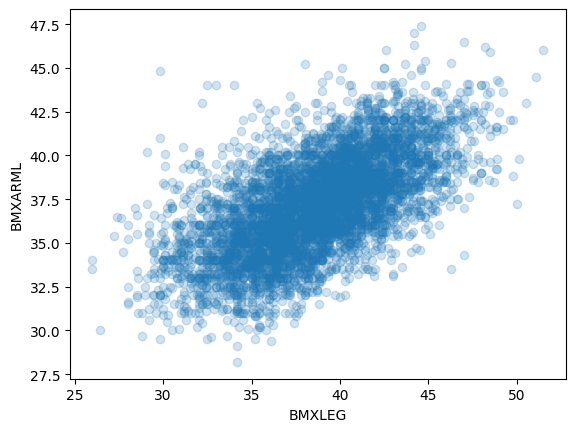

In [3]:
sns.regplot(x='BMXLEG', y='BMXARML', data=da, fit_reg=False, scatter_kws={'alpha':0.2})

Another way to avoid overplotting is to make a plot of the "density" of points. In the plots below, darker colors indicate where a greater number of points fall. The plots along the axes show the one-dimensional marginal densities for the arm lengths and leg lengths separately, while the plot in the center shows their joint density

This plot also shows the Pearson correlation coefficient between the arm length and leg length, which is 0.62. As discussed in the course, the Pearson correlation coefficient ranges from -1 to 1, with values approaching 1 indicating a more perfect positive dependence. In many settings, a correlation of 0.62 would be considered a moderately strong positive dependence.

Text(0.1, 0.9, 'r=0.62')

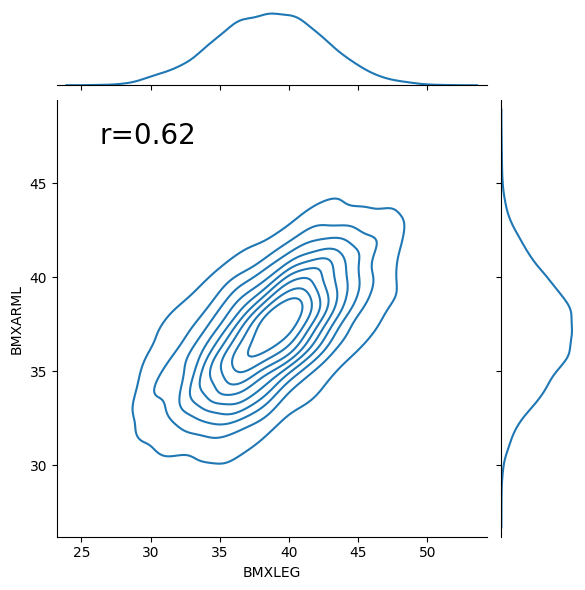

In [4]:
p = sns.jointplot(x='BMXLEG', y='BMXARML', kind='kde', data=da)
r = da[['BMXLEG','BMXARML']].corr().iloc[0,1]
p.ax_joint.annotate('r=%.2f' %r, xy=(0.1, 0.9), xycoords='axes fraction', size=20)

As another example with slightly different behavior, we see that systolic and diastolic blood pressure are more weakly correlated than arm and leg length, with a correlation coefficient of 0.32. This weaker correlation indicates that some people have unusually high systolic blood pressure but have average diastolic blood pressure, and vice versa.

Text(0.1, 0.9, 'r=0.32')

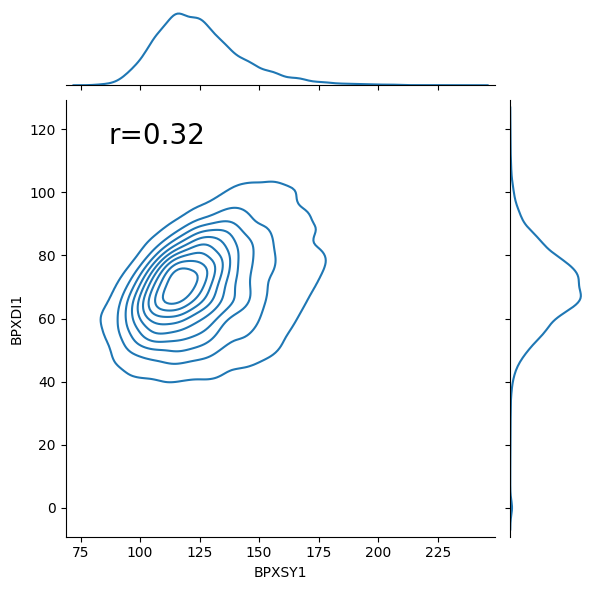

In [5]:
p = sns.jointplot(x='BPXSY1', y='BPXDI1', kind='kde', data=da)
r = da[['BPXSY1','BPXDI1']].corr().iloc[0,1]
p.ax_joint.annotate('r=%.2f' %r, xy=(0.1, 0.9),xycoords='axes fraction',size=20)

Next we look at two repeated measures of systolic blood pressure, taken a few minutes apart on the same person. These values are very highly correlated, with a correlation coefficient of around 0.96.

Text(0.1, 0.9, 'r=0.96')

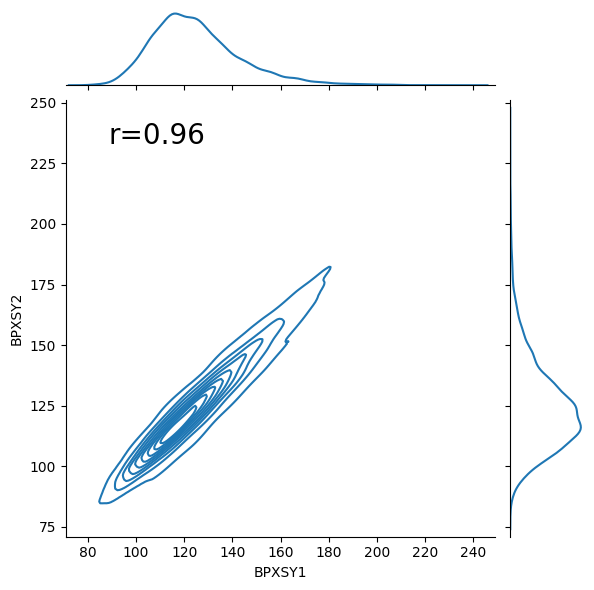

In [7]:
p = sns.jointplot(x='BPXSY1', y='BPXSY2', kind='kde', data=da)
r = da[['BPXSY1','BPXSY2']].corr().iloc[0,1]
p.ax_joint.annotate('r=%.2f' %r, xy=(0.1, 0.9), xycoords='axes fraction', size=20)

#### Heterogeneity and stratification

Most human characteristics vary in a complex manner -- for example they may vary by gender, age, ethnicity, and other factors. This type of variation is often referred to as "heterogeneity". When such heterogeneity is present, it is usually productive to explore the data more deeply by stratifying on relevant factors, as we did in the univariate analyses.

Below, we continue to probe the relationship between leg length and arm length, stratifying first by gender, then by gender and ethnicity. The gender-stratified plot indicates that men tend to have somewhat longer arms and legs than women -- this is reflected in the fact that the cloud of points on the left is shifted slightly up and to the right relative to the cloud of points on the right. In addition, the correlation between arm length and leg length appears to be somewhat weaker in women than in men.

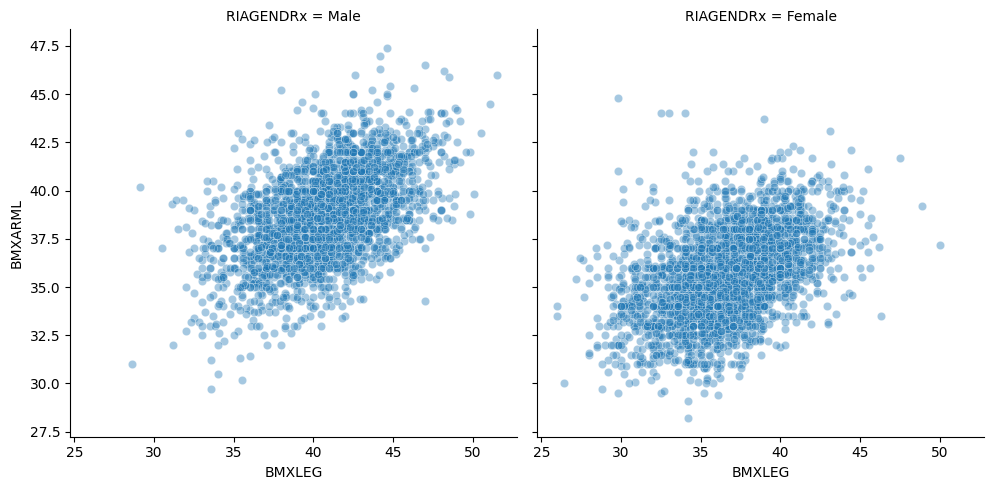

In [9]:
da['RIAGENDRx'] = da['RIAGENDR'].replace({1:'Male',2:'Female'})
sns.FacetGrid(data=da, col='RIAGENDRx', height=5).map(sns.scatterplot, 'BMXLEG', 'BMXARML', alpha=0.4).add_legend()

Consistent with the scatterplot, a slightly weaker correlation between arm length and leg length in women (compared to men) can be seen by calculating the correlation coefficient separately within each gender.

The corr method of a dataframe calculates the correlation coefficients for every pair of variables in the dataframe. This method returns a "correlation matrix", which is a table containing the correlations between every pair of variables in the data set. Note that the diagonal of a correlation matrix always contains 1's, since a variable always has correlation 1 with itself. The correlation matrix is also symmetric around this diagonal, since the correlation between two variables 'X' and 'Y' does not depend on the order in which we consider the two variables.

In the results below, we see that the correlation between leg length and arm length in men is 0.50, while in women the correlation is 0.43.

In [14]:
print(da[da['RIAGENDRx']=='Female'][['BMXLEG','BMXARML']].corr())
print(da[da['RIAGENDRx']=='Male'][['BMXLEG','BMXARML']].corr())

           BMXLEG   BMXARML
BMXLEG   1.000000  0.434703
BMXARML  0.434703  1.000000
           BMXLEG   BMXARML
BMXLEG   1.000000  0.505426
BMXARML  0.505426  1.000000


Next we look to stratifying the data by both gender and ethnicity. This results in 2 x 5 = 10 total strata, since there are 2 gender strata and 5 ethnicity strata. 

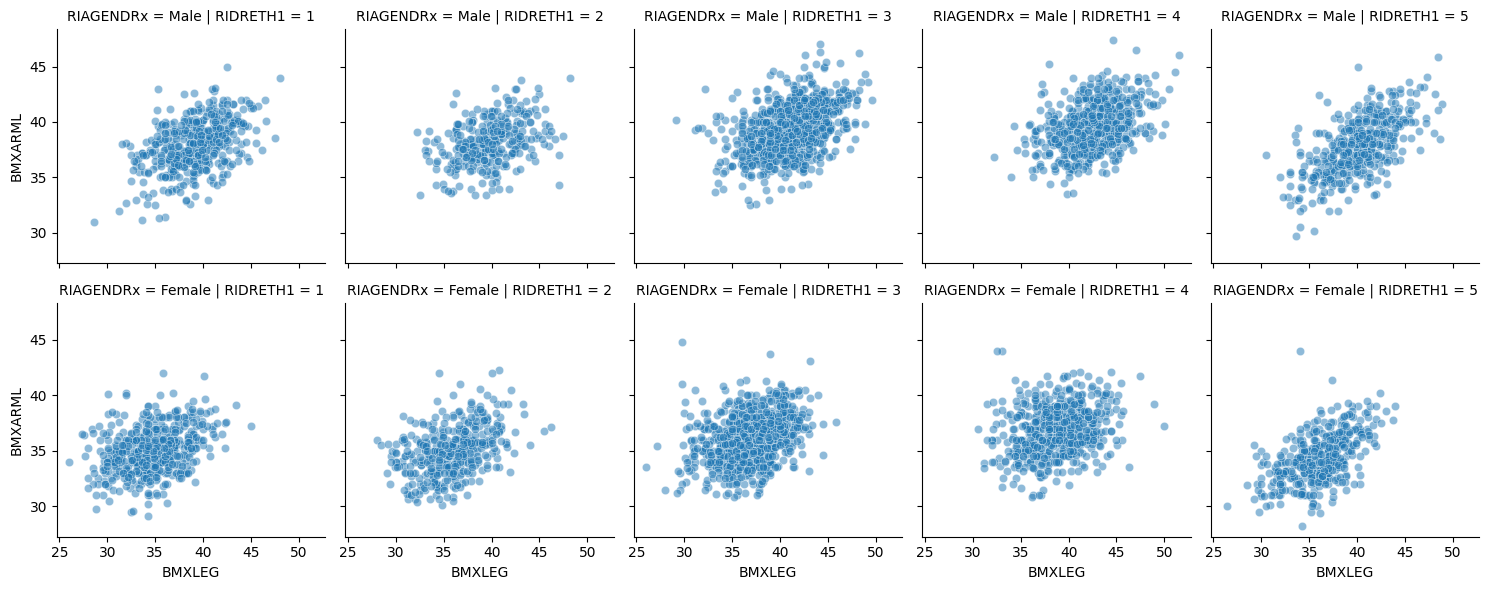

In [17]:
sns.FacetGrid(da, col='RIDRETH1', row='RIAGENDRx').map(sns.scatterplot, 'BMXLEG', 'BMXARML', alpha=0.5).add_legend()

#### Categorical bivariate data

In this section we discuss some methods for working with bivariate data that are categorical. We can start with a contingency table, which counts the number of people having each combination of two factors. To illustrate, we will consider the NHANES variables for marital status and education level.

First, we create new versions of these two variables using text labels instead of numbers to represent the categories. We also create a new data set that omits people who responded "Don't know" or who refused to answer these questions.

In [18]:
da["DMDEDUC2x"] = da.DMDEDUC2.replace({1: "<9", 2: "9-11", 3: "HS/GED", 4: "Some college/AA", 5: "College", 
                                       7: "Refused", 9: "Don't know"})
da["DMDMARTLx"] = da.DMDMARTL.replace({1: "Married", 2: "Widowed", 3: "Divorced", 4: "Separated", 5: "Never married",
                                      6: "Living w/partner", 77: "Refused"})
db = da.query('''DMDEDUC2x != "Don't know" & DMDMARTLx != "Refused"''')
db

,SEQN,ALQ101,ALQ110,ALQ130,SMQ020,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,...,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,HIQ210,RIAGENDRx,DMDEDUC2x,DMDMARTLx
0,83732,1.0,NaN,1.0,1,1,62,3,1.0,5.0,...,184.5,27.8,43.3,43.6,35.9,101.1,2.0,Male,College,Married
1,83733,1.0,NaN,6.0,1,1,53,3,2.0,3.0,...,171.4,30.8,38.0,40.0,33.2,107.9,NaN,Male,HS/GED,Divorced
2,83734,1.0,NaN,NaN,1,1,78,3,1.0,3.0,...,170.1,28.8,35.6,37.0,31.0,116.5,2.0,Male,HS/GED,Married
3,83735,2.0,1.0,1.0,2,2,56,3,1.0,5.0,...,160.9,42.4,38.5,37.7,38.3,110.1,2.0,Female,College,Living w/partner
4,83736,2.0,1.0,1.0,2,2,42,4,1.0,4.0,...,164.9,20.3,37.4,36.0,27.2,80.4,2.0,Female,Some college/AA,Divorced
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5730,93695,2.0,2.0,NaN,1,2,76,3,1.0,3.0,...,165.8,21.5,38.2,37.0,29.5,95.0,2.0,Female,HS/GED,Widowed
5731,93696,2.0,2.0,NaN,2,1,26,3,1.0,5.0,...,182.2,33.8,43.4,41.8,42.3,110.2,2.0,Male,College,Married
5732,93697,1.0,NaN,1.0,1,2,80,3,1.0,4.0,...,152.2,31.0,31.3,37.5,28.8,NaN,2.0,Female,Some college/AA,Widowed
5733,93700,NaN,NaN,NaN,1,1,35,3,2.0,1.0,...,173.3,26.0,40.3,37.5,30.6,98.9,2.0,Male,<9,Married


Now we can create a contingency table counting the number of people in each cell defined by a combination of education and marital status

In [19]:
x = pd.crosstab(db['DMDEDUC2x'],db['DMDMARTLx'])
x

DMDMARTLx,Divorced,Living w/partner,Married,Never married,Separated,Widowed
DMDEDUC2x,,,,,,
9-11,62,80,305,117,39,40
<9,52,66,341,65,43,88
College,120,85,827,253,22,59
HS/GED,127,133,550,237,40,99
Some college/AA,217,163,757,332,42,108


The results would be easier to interpret if we normalize the data. We can normalize data in three different ways
1. Make the rows sum to one 
2. Make the columns sum to one
3. Make the whole table sum to one

lets normalize the <u>rows</u> 

In [20]:
x.apply(lambda z: z/z.sum(), axis=1)

DMDMARTLx,Divorced,Living w/partner,Married,Never married,Separated,Widowed
DMDEDUC2x,,,,,,
9-11,0.096423,0.124417,0.474339,0.181960,0.060653,0.062208
<9,0.079389,0.100763,0.520611,0.099237,0.065649,0.134351
College,0.087848,0.062225,0.605417,0.185212,0.016105,0.043192
HS/GED,0.107083,0.112142,0.463744,0.199831,0.033727,0.083474
Some college/AA,0.134033,0.100679,0.467573,0.205065,0.025942,0.066708


now lets normalize the <u>columns</u>

In [21]:
x.apply(lambda z: z/z.sum(), axis=0)

DMDMARTLx,Divorced,Living w/partner,Married,Never married,Separated,Widowed
DMDEDUC2x,,,,,,
9-11,0.107266,0.151803,0.109712,0.116534,0.209677,0.101523
<9,0.089965,0.125237,0.122662,0.064741,0.231183,0.223350
College,0.207612,0.161290,0.297482,0.251992,0.118280,0.149746
HS/GED,0.219723,0.252372,0.197842,0.236056,0.215054,0.251269
Some college/AA,0.375433,0.309298,0.272302,0.330677,0.225806,0.274112


It is quite plausible that there are gender differences in the relationship between educational attainment and marital status.  Therefore we can look at the proportion of people in each marital status category, for each combination of the gender and education variables.  This analyses yields some interesting trends, notably that women are much more likely to be widowed or divorced than men (e.g. women in the HS/GED group are around 3 times more likely to be widowed than men in the HS/GED group).

In [29]:
# The following line does these steps, reading the code from left to right:
# 1 Group the data by every combination of gender, education, and marital status
# 2 Count the number of people in each cell using the 'size' method
# 3 Pivot the marital status results into the columns (using unstack)
# 4 Fill any empty cells with 0
# 5 Normalize the data by row
db.groupby(["RIAGENDRx", "DMDEDUC2x", "DMDMARTLx"]).size().unstack().fillna(0).apply(lambda z: z/z.sum(), axis=1)

DMDMARTLx                  Divorced  Living w/partner   Married  \
RIAGENDRx DMDEDUC2x                                               
Female    9-11             0.113402          0.123711  0.412371   
          <9               0.091691          0.091691  0.424069   
          College          0.110181          0.055788  0.577406   
          HS/GED           0.121784          0.109777  0.413379   
          Some college/AA  0.148678          0.099119  0.418502   
Male      9-11             0.082386          0.125000  0.525568   
          <9               0.065359          0.111111  0.630719   
          College          0.063174          0.069337  0.636364   
          HS/GED           0.092869          0.114428  0.512438   
          Some college/AA  0.115331          0.102672  0.530239   

DMDMARTLx                  Never married  Separated   Widowed  
RIAGENDRx DMDEDUC2x                                            
Female    9-11                  0.171821   0.075601  0.103093  
          <9                    0.108883   0.088825  0.194842  
          College               0.182706   0.016736  0.057183  
          HS/GED                0.188679   0.041166  0.125214  
          Some college/AA       0.210352   0.031938  0.091410  
Male      9-11                  0.190341   0.048295  0.028409  
          <9                    0.088235   0.039216  0.065359  
          College               0.187982   0.015408  0.027735  
          HS/GED                0.210614   0.026534  0.043118  
          Some college/AA       0.198312   0.018284  0.035162

One factor behind the greater number of women who are divorced and widowed could be that women live longer than men. To minimize the impact of this factor, we can recalculate the above table using a few narrow bands of ages. To simplify here, we collapse the marital status data to characterize people as being either "married" or "unmarried" This allows us to focus on the marriage rate, which is a widely-studied variable in social science research.

There are a number of intriguing results here. For example, the marriage rate seems to drop as college-educated people get older (e.g. 71% of college educated women between 49 and 50 are married, but only 65% of college educated women between 50 and 59 are married, an even larger drop occurs for men). However in people with a HS/GED level of education, the marriage rate is higher for older people (although it is lower compared to the college educated sample). There are a number of possible explanations for this, for example, that remarriage after divorce is less common among college graduates.

In [59]:
dx = db.query('RIDAGEYR >= 40 & RIDAGEYR < 50')
a = dx.groupby(["RIAGENDRx", "DMDEDUC2x", "DMDMARTLx"]).size().unstack().fillna(0).apply(lambda z: z/z.sum(),axis=1)

dx = db.query('RIDAGEYR >= 50 & RIDAGEYR < 60')
b = dx.groupby(["RIAGENDRx", "DMDEDUC2x", "DMDMARTLx"]).size().unstack().fillna(0).apply(lambda z: z/z.sum(),axis=1)

print(a['Married'].unstack())
print("")
print(b['Married'].unstack())

DMDEDUC2x      9-11        <9   College    HS/GED  Some college/AA
RIAGENDRx                                                         
Female     0.581818  0.464286  0.713376  0.476744         0.509554
Male       0.574074  0.714286  0.879310  0.616279         0.625000

DMDEDUC2x      9-11        <9   College    HS/GED  Some college/AA
RIAGENDRx                                                         
Female     0.490566  0.511111  0.648649  0.563107         0.496403
Male       0.666667  0.622642  0.737374  0.637255         0.555556


We conclude this section by noting that marital status is associated with many factors, including gender and eduational status, but also varies strongly by age and birth cohort. For example, it is unlikely for young people to be widowed, and it is less likely for older people to be "never married", since a person can transition from "never married" into one of the other categories, but can never move back. Below we will consider the role of age in more detail.

#### Mixed categorical and quantitative data

Another situation that commonly arises in data analysis is when we wish to analyze bivariate data consisting of one quantitative and one categorical variable. To illustrate methods that can be used in this setting, we consider the relationship between marital status and age in the NHANES data. Specifically, we consider the distribution of ages for people who are currently in each marital status category. A natural tool in this setting is side-by-side boxplots. Here we see some unsurprising things -- widowed people tend to be older, and never-married people tend to be younger.

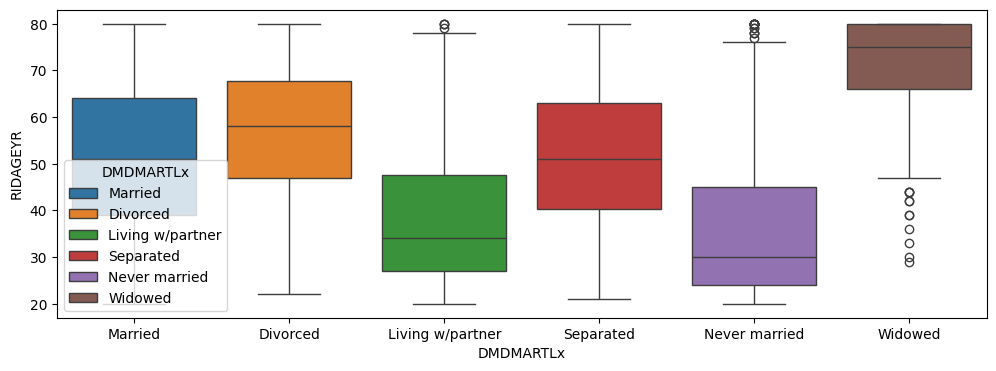

In [66]:
plt.figure(figsize=(12, 4))
a = sns.boxplot(x=db['DMDMARTLx'], y=db['RIDAGEYR'], hue=db['DMDMARTLx'])

When we have enough data, a "violinplot" gives a bit more insight into the shapes of the distributions compared to a traditional boxplot. The violinplot below is based on the same data as the boxplot above. We can see quite clearly that the distributions with low mean (living with partner, never married) are strongly right-skewed, while the distribution with high mean (widowed) is strongly left-skewed. The other distributions have intermediate mean values, and are approximately symmetrically distributed

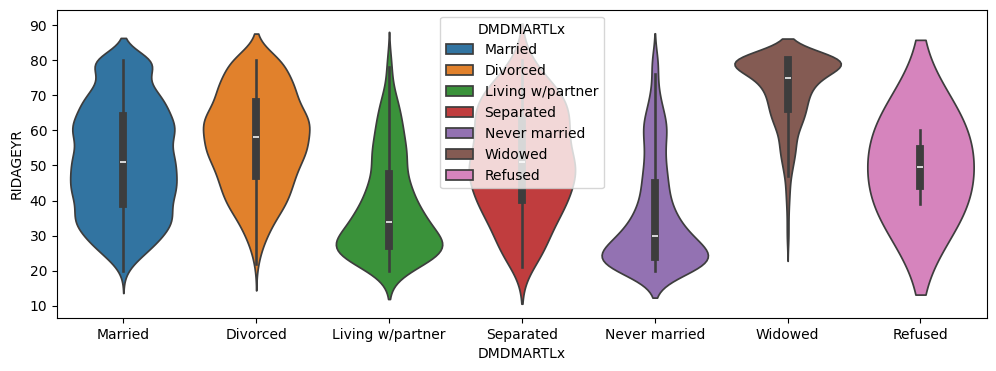

In [69]:
plt.figure(figsize=(12, 4))
a = sns.violinplot(x=da['DMDMARTLx'], y=da['RIDAGEYR'], hue=da['DMDMARTLx'])